<a href="https://colab.research.google.com/github/AtSourav/CatsnDogs_VAE/blob/main/MNIST_varying_beta_l12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt


In [2]:
input_size = (28,28,1)
latent_dim = 12
batch_size = 64

In [3]:
(img_train, tg_train), (img_valid, tg_valid) = mnist.load_data()

img_ht = img_train.shape[1]
img_wd = img_train.shape[2]
count_train = img_train.shape[0]
count_valid = img_valid.shape[0]

img_train = img_train.reshape(count_train,img_ht,img_wd, 1)
img_valid = img_valid.reshape(count_valid,img_ht,img_wd, 1)

img_train = img_train/255.
img_valid = img_valid/255.

print(img_train.shape)
print(img_valid.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
# we'll keep a train:valid split of 80:20, so we'll keep only 40k of the training images. this is to save some time training.

In [4]:
img_train = img_train[:40000]
print(img_train.shape)

(40000, 28, 28, 1)


In [5]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(8, 2, padding="valid")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")(x)    # with strides=None this defaults to pool_size
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization(axis=-1)(x) # the default data_format in the conv2d is "channels last", we want to normalize across the channels, hence we set axis=-1
x = layers.ReLU()(x)

x = layers.Conv2D(16, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid")(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="valid")(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

#x = layers.Dense(8*latent_dim)(x)
x = layers.Dense(2*latent_dim)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])   # we feed the sampling function in to a Lambda layer to build form a layer for the architecture as keras needs

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')           # the second argument specifies that the encoder outputs [z_mean, z_log_var, z] for each input.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 27, 27, 8)            40        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)            0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 re_lu (ReLU)                (None, 14, 14, 8)            0         ['max_pooling2d[0][0]'] 

In [6]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Dense(32)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Dense(64)(x)
# = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Reshape((1,1,64))(x)

x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(8, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(1, 2, activation='sigmoid', strides=2, padding='same')(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 re_lu_6 (ReLU)              (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                800       
                                                                 
 re_lu_7 (ReLU)              (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 re_lu_8 (ReLU)              (None, 64)                0   

In [7]:
decoder_out = decoder(encoder(encoder_input)[2])          # we feed in z from the encoder output
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 12),              17192     
                              (None, 12),                        
                              (None, 12)]                        
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         18193     
                                                                 
Total params: 35385 (138.22 KB)
Trainable params: 35385 (138.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **beta = 1**

In [8]:
beta=1

def vae_loss_1(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [ ]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.993, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_1)

In [ ]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=250, steps_per_epoch=None)

Epoch 1/150
625/625 [==============================] - 28s 15ms/step - loss: 223.4176 - val_loss: 195.8358
Epoch 2/150
625/625 [==============================] - 8s 12ms/step - loss: 192.5224 - val_loss: 188.8704
Epoch 3/150
625/625 [==============================] - 8s 12ms/step - loss: 183.0699 - val_loss: 177.0877
Epoch 4/150
625/625 [==============================] - 7s 11ms/step - loss: 174.4982 - val_loss: 171.5520
Epoch 5/150
625/625 [==============================] - 8s 12ms/step - loss: 170.3591 - val_loss: 167.8737
Epoch 6/150
625/625 [==============================] - 7s 12ms/step - loss: 164.3684 - val_loss: 160.2900
Epoch 7/150
625/625 [==============================] - 8s 12ms/step - loss: 157.4014 - val_loss: 154.8969
Epoch 8/150
625/625 [==============================] - 7s 12ms/step - loss: 153.3444 - val_loss: 151.7587
Epoch 9/150
625/625 [==============================] - 7s 12ms/step - loss: 150.9458 - val_loss: 149.7569
Epoch 10/150
625/625 [=======================

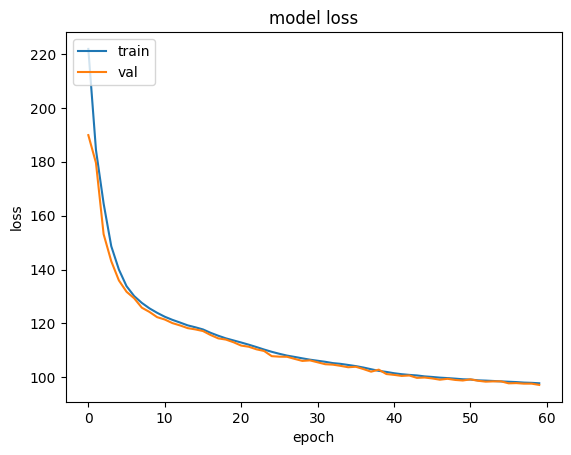

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
def plot_reconstruction(set, name,seed_val, epochs, beta):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 100)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  _,_,z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  digits_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  digits_recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, beta='+str(beta)+', latent_dim = 12', fontweight= 'bold', y=0.93)

  digits_recon.tight_layout()

  for i in range(210):
    digits_recon.add_subplot(10,21,i+1)
    j = int(np.floor(i/21))
    if (i%21) <10:
      img = set[tg_indices[j*10 + (i%21)]]
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    elif (i%21)==10:
      img = np.ones((14,14,1))
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    else:
      img = img_recon[j*10 + (i%21) - 11]
      plt.imshow(img, cmap='gray')
      plt.axis('off')

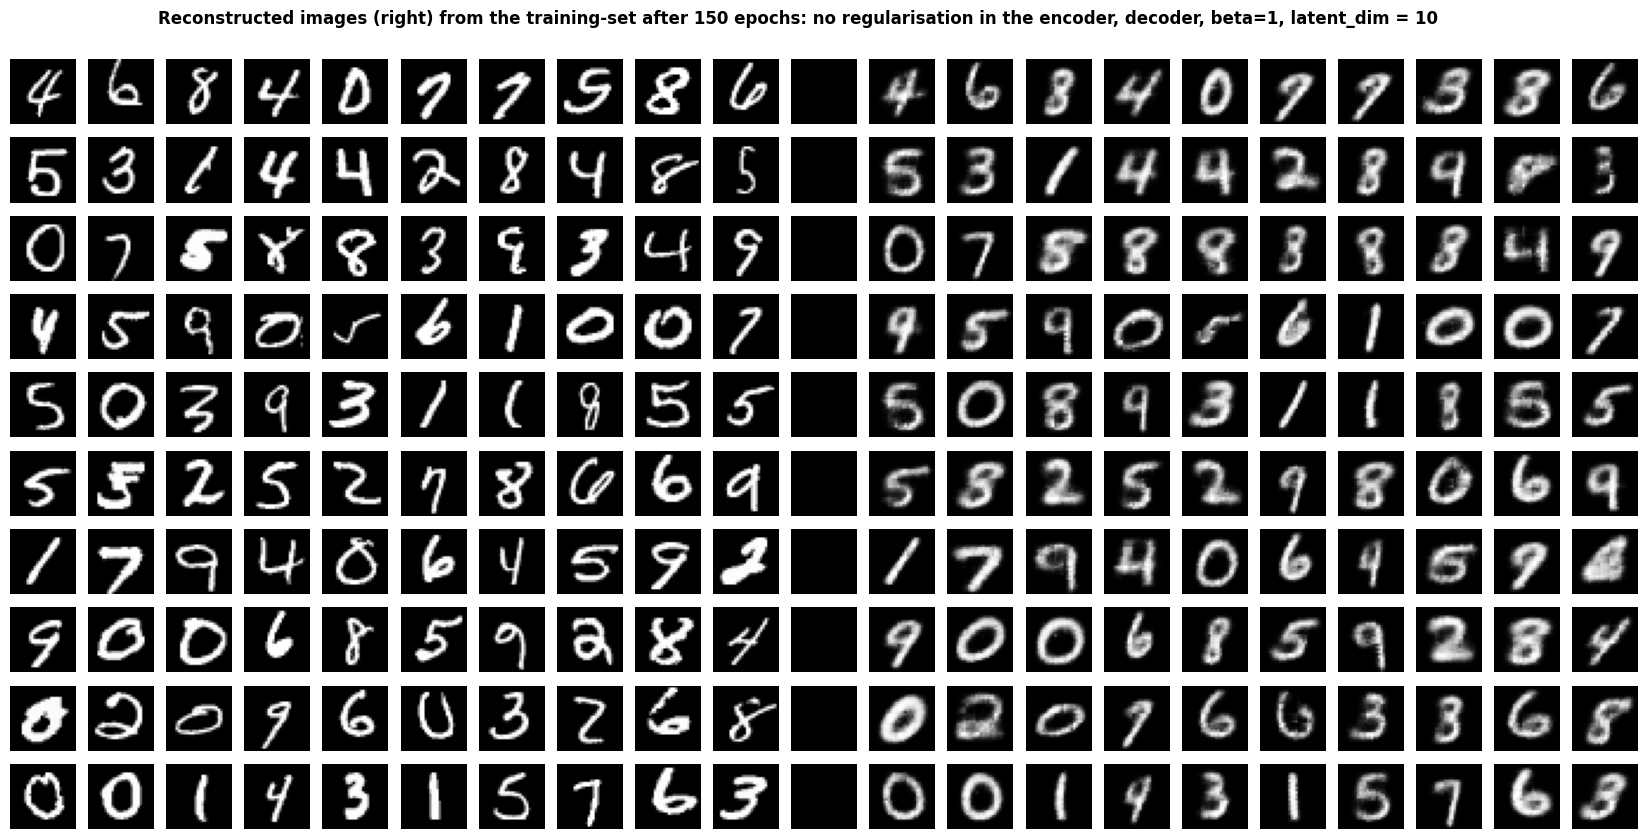

In [ ]:
plot_reconstruction(img_train,'training',200,150)

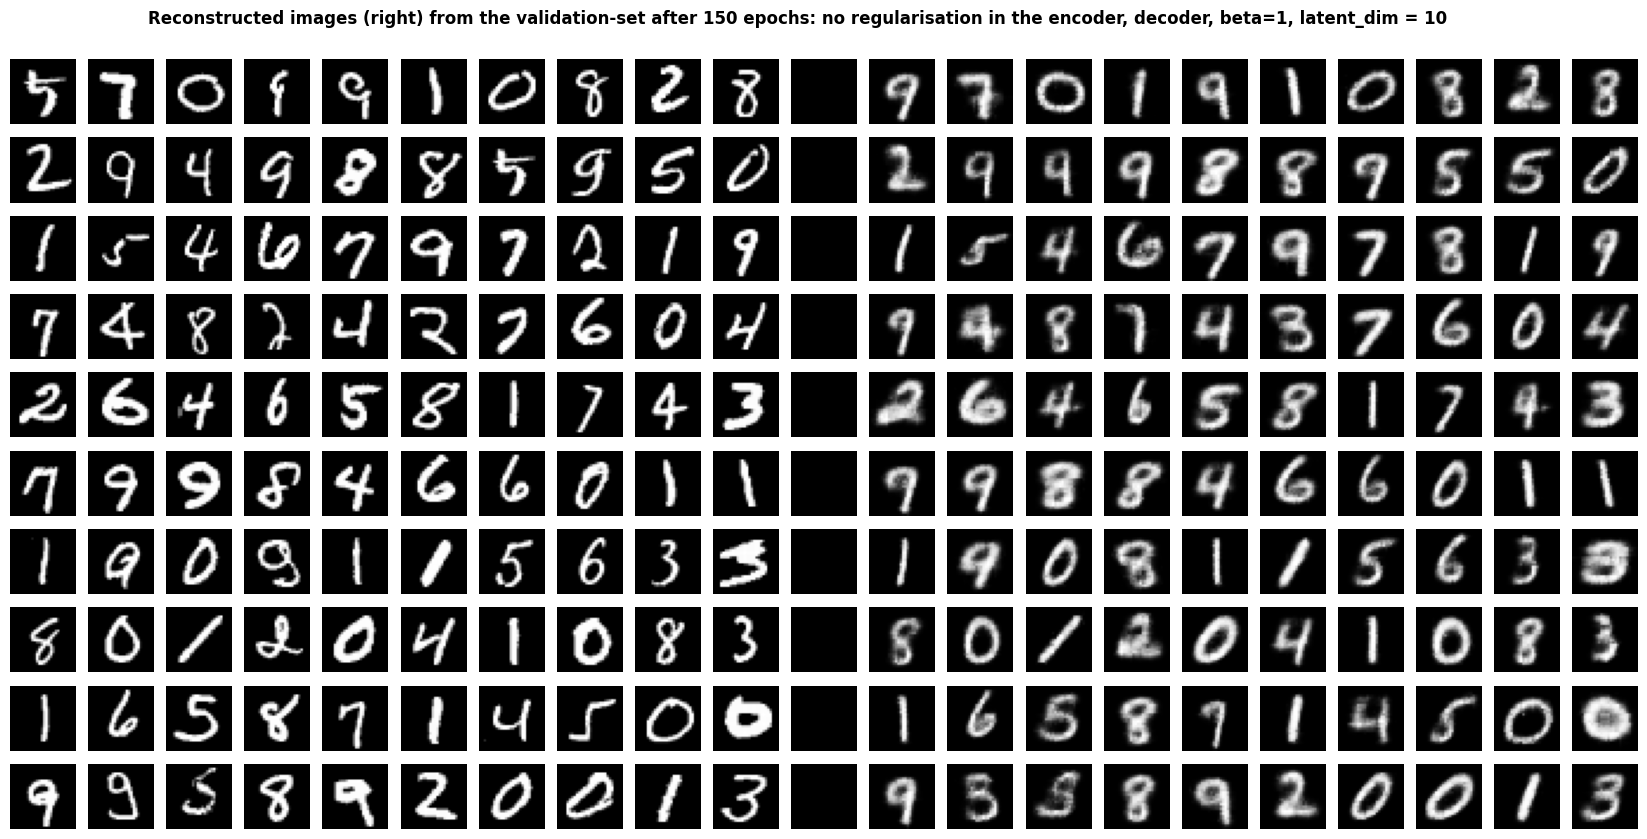

In [ ]:
plot_reconstruction(img_valid,'validation',500,150)

In [11]:
def plot_generated(scale,edge, seed_val, epochs, beta):   # edge is the length of the square grid we want to create
  np.random.seed(seed_val)
  z_rand = tf.convert_to_tensor(-scale + 2*scale*np.random.random((edge**2,latent_dim)))

  img_rand = decoder(z_rand)

  digits_rand = plt.figure(figsize=(edge,edge))
  digits_rand.suptitle('Some randomly generated images (after '+ str(epochs) + ' epochs of training): no regularisation in the encoder, decoder, beta='+str(beta)+'1, latent_dim = 10', fontweight= 'bold', y=0.93)


  for i in range(edge**2):
    digits_rand.add_subplot(edge,edge,i+1)
    img = img_rand[i]
    plt.imshow(img, cmap='gray')
    plt.axis('off')



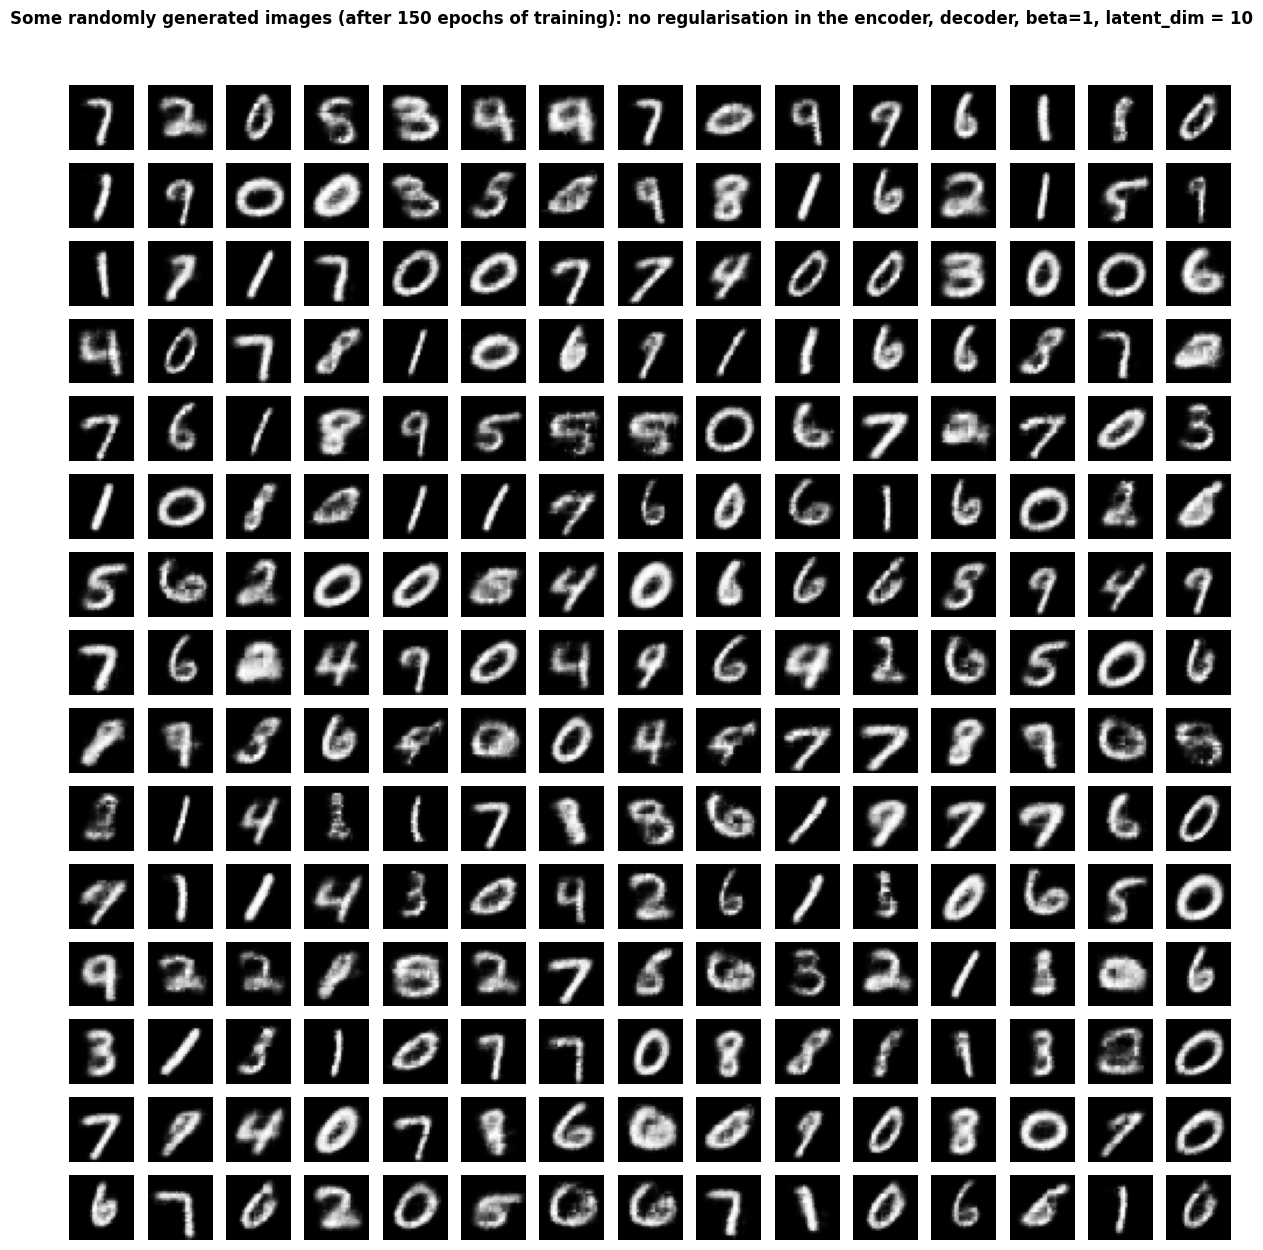

In [ ]:
 plot_generated(2,15,111,150)

From an inspection of the images, it seems like the training set images are indeed reconstructed slightly better than the validation set images. This is understandable as the loss plots seems to indicate that the performance is very slightly better on the training set than on the validation set.   

We shall take this to further extremes by taking a low value of beta which should suppress the kl div term w.r.t. the reconstruction term.

## **beta=0.01**

In [ ]:
beta=0.01

def vae_loss_2(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [ ]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.994, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_2)

In [ ]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=200, steps_per_epoch=None)

Epoch 1/100
625/625 [==============================] - 8s 13ms/step - loss: 86.4874 - val_loss: 86.6367
Epoch 2/100
625/625 [==============================] - 8s 12ms/step - loss: 86.4508 - val_loss: 86.6026
Epoch 3/100
625/625 [==============================] - 8s 12ms/step - loss: 86.4274 - val_loss: 86.3261
Epoch 4/100
625/625 [==============================] - 8s 13ms/step - loss: 86.4770 - val_loss: 86.0894
Epoch 5/100
625/625 [==============================] - 8s 13ms/step - loss: 86.3500 - val_loss: 86.0681
Epoch 6/100
625/625 [==============================] - 8s 13ms/step - loss: 86.3715 - val_loss: 86.1413
Epoch 7/100
625/625 [==============================] - 8s 13ms/step - loss: 86.3885 - val_loss: 86.2913
Epoch 8/100
625/625 [==============================] - 7s 12ms/step - loss: 86.3410 - val_loss: 86.8559
Epoch 9/100
625/625 [==============================] - 8s 13ms/step - loss: 86.2984 - val_loss: 86.3078
Epoch 10/100
625/625 [==============================] - 10s 15ms

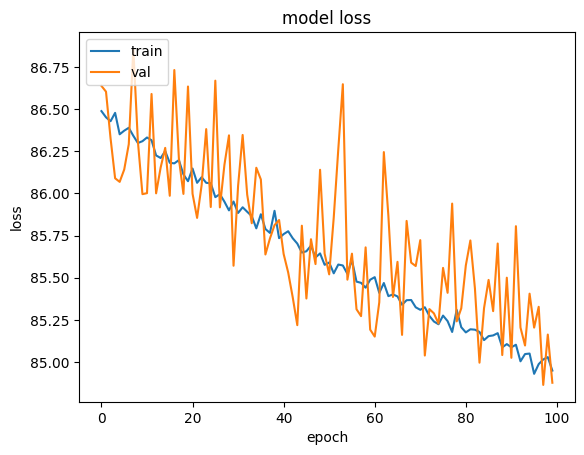

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

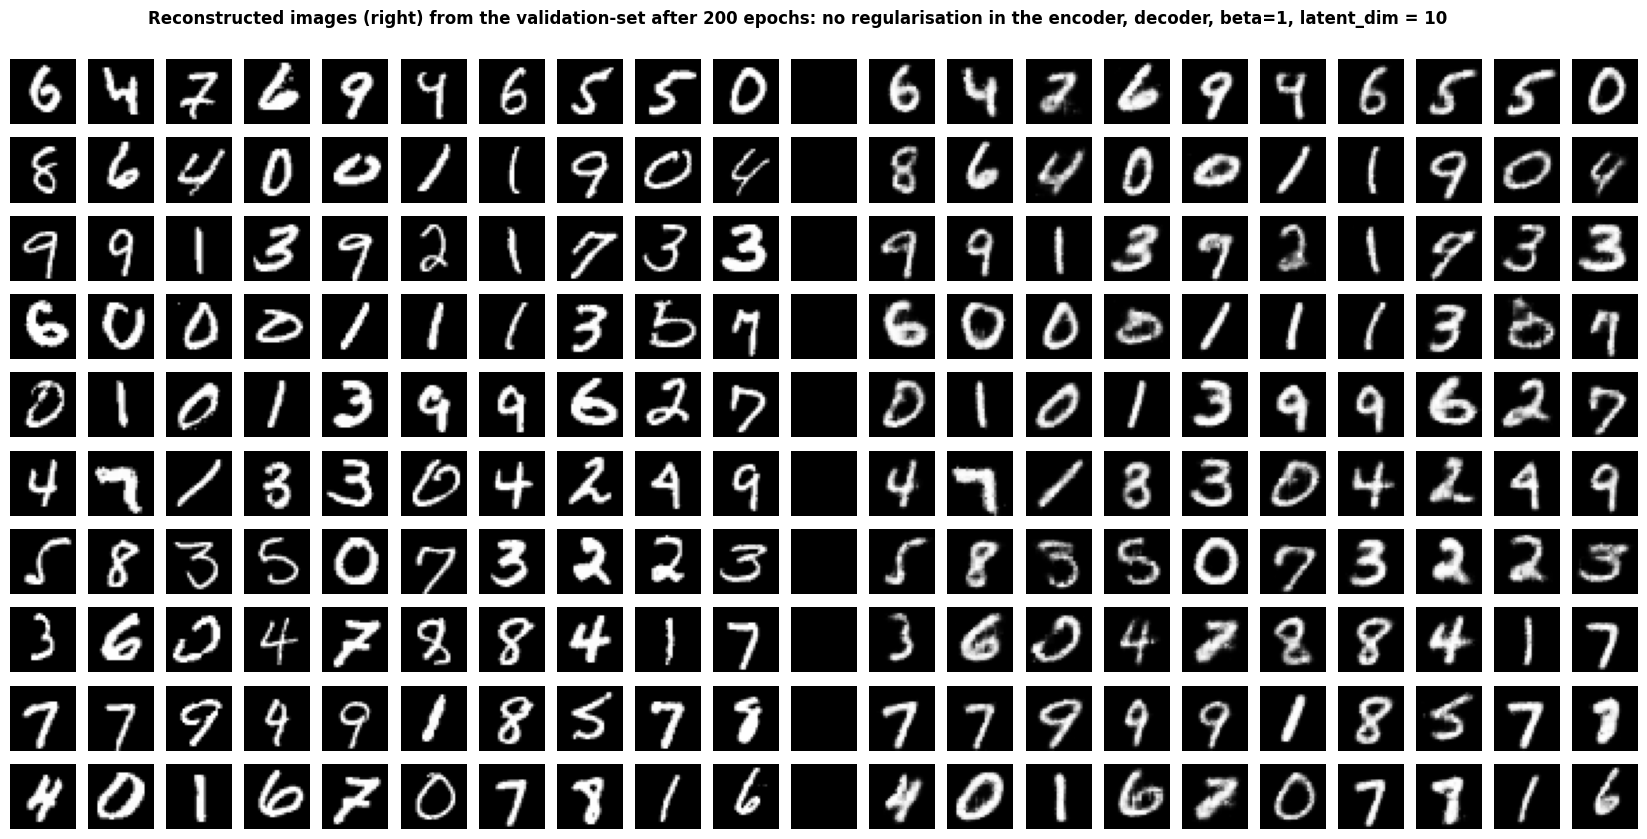

In [ ]:
plot_reconstruction(img_valid,'validation',200,200)

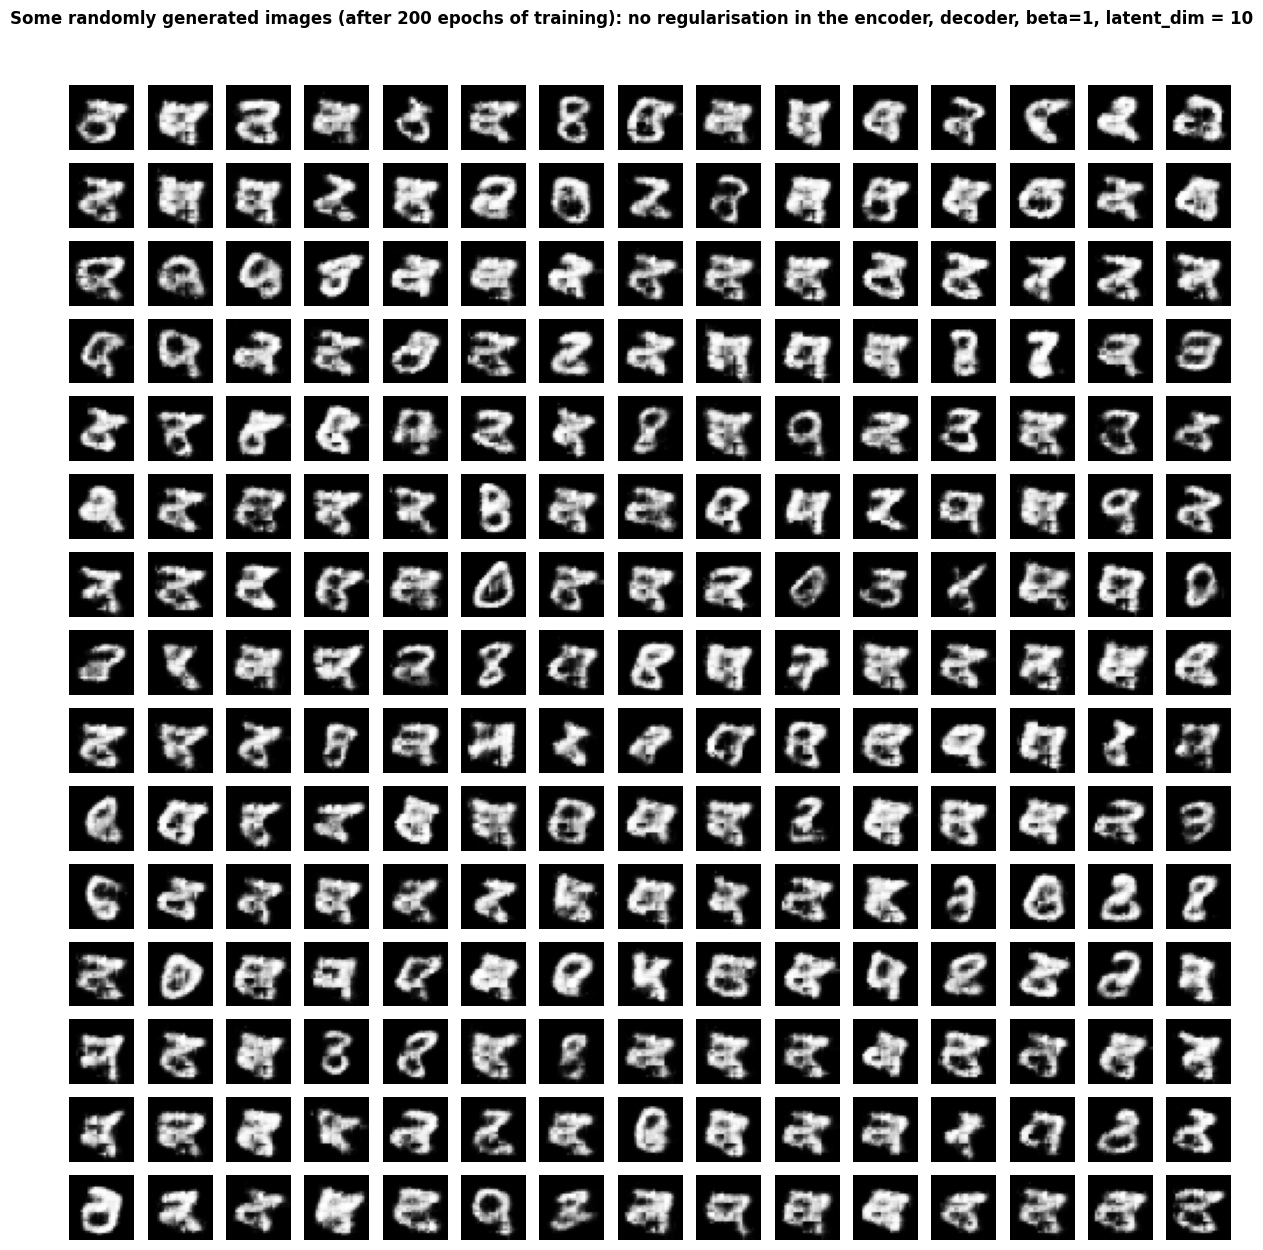

In [ ]:
plot_generated(1,15,111,200)

## **beta=10**

In [12]:
beta=10

def vae_loss_3(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [13]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=50000, decay_rate=0.9885, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_3)

In [14]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=250, steps_per_epoch=None)

Epoch 1/250
625/625 [==============================] - 24s 13ms/step - loss: 227.9928 - val_loss: 206.5320
Epoch 2/250
625/625 [==============================] - 9s 14ms/step - loss: 205.9691 - val_loss: 204.5069
Epoch 3/250
625/625 [==============================] - 13s 21ms/step - loss: 204.2691 - val_loss: 203.2455
Epoch 4/250
625/625 [==============================] - 11s 18ms/step - loss: 202.5183 - val_loss: 200.9246
Epoch 5/250
625/625 [==============================] - 11s 18ms/step - loss: 200.7050 - val_loss: 199.6066
Epoch 6/250
625/625 [==============================] - 11s 18ms/step - loss: 199.9485 - val_loss: 199.0652
Epoch 7/250
625/625 [==============================] - 8s 13ms/step - loss: 199.5037 - val_loss: 198.3844
Epoch 8/250
625/625 [==============================] - 7s 11ms/step - loss: 198.9573 - val_loss: 197.7103
Epoch 9/250
625/625 [==============================] - 7s 12ms/step - loss: 198.4581 - val_loss: 197.3417
Epoch 10/250
625/625 [===================

In [17]:
#lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=50000, decay_rate=0.9885, staircase=True)
optim = keras.optimizers.Adam(learning_rate = 0.0005)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history2 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 13ms/step - loss: 189.1063 - val_loss: 188.7708
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 189.0711 - val_loss: 188.2622
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 189.4166 - val_loss: 189.4580
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 189.7774 - val_loss: 189.0972
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 189.4861 - val_loss: 189.1853
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 190.4439 - val_loss: 190.0297
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 191.9658 - val_loss: 194.3085
Epoch 8/10
625/625 [==============================] - 7s 12ms/step - loss: 194.2771 - val_loss: 193.4754
Epoch 9/10
625/625 [==============================] - 6s 10ms/step - loss: 193.5483 - val_loss: 191.7860
Epoch 10/10
625/625 [==============================] -

In [19]:
optim = keras.optimizers.Adam(learning_rate = 0.0002)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history3 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 11ms/step - loss: 190.1324 - val_loss: 189.4115
Epoch 2/10
625/625 [==============================] - 7s 12ms/step - loss: 189.8324 - val_loss: 189.4924
Epoch 3/10
625/625 [==============================] - 7s 10ms/step - loss: 190.0177 - val_loss: 190.0433
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 190.0497 - val_loss: 190.0234
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 189.8888 - val_loss: 189.2758
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 189.3557 - val_loss: 189.0127
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 189.2267 - val_loss: 189.0544
Epoch 8/10
625/625 [==============================] - 6s 10ms/step - loss: 189.2942 - val_loss: 189.0459
Epoch 9/10
625/625 [==============================] - 7s 11ms/step - loss: 189.3598 - val_loss: 188.7984
Epoch 10/10
625/625 [==============================] -

In [20]:
optim = keras.optimizers.Adam(learning_rate = 0.0001)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history4 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 13ms/step - loss: 189.0019 - val_loss: 188.5612
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 188.9047 - val_loss: 188.3703
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 188.7526 - val_loss: 188.5116
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 188.8443 - val_loss: 188.1833
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 188.8517 - val_loss: 188.2684
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 188.7313 - val_loss: 188.2677
Epoch 7/10
625/625 [==============================] - 7s 10ms/step - loss: 188.7345 - val_loss: 188.2614
Epoch 8/10
625/625 [==============================] - 7s 11ms/step - loss: 188.7267 - val_loss: 188.4590
Epoch 9/10
625/625 [==============================] - 6s 10ms/step - loss: 188.8372 - val_loss: 188.6617
Epoch 10/10
625/625 [==============================] -

In [21]:
optim = keras.optimizers.Adam(learning_rate = 0.00009)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history5 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 11ms/step - loss: 188.9158 - val_loss: 188.2842
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 188.7974 - val_loss: 188.3894
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 188.6439 - val_loss: 188.0159
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 188.4936 - val_loss: 188.3061
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 188.4954 - val_loss: 188.2497
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 188.5756 - val_loss: 187.9398
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 188.5484 - val_loss: 188.1189
Epoch 8/10
625/625 [==============================] - 6s 10ms/step - loss: 188.4888 - val_loss: 188.1852
Epoch 9/10
625/625 [==============================] - 7s 11ms/step - loss: 188.5880 - val_loss: 188.1283
Epoch 10/10
625/625 [==============================] -

In [22]:
optim = keras.optimizers.Adam(learning_rate = 0.000075)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history6 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 11ms/step - loss: 188.4799 - val_loss: 188.0959
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 188.5504 - val_loss: 188.0022
Epoch 3/10
625/625 [==============================] - 7s 10ms/step - loss: 188.4685 - val_loss: 188.1997
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 188.3934 - val_loss: 188.0405
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 188.4266 - val_loss: 188.0366
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 188.3819 - val_loss: 187.9649
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 188.2918 - val_loss: 187.9777
Epoch 8/10
625/625 [==============================] - 7s 10ms/step - loss: 188.4494 - val_loss: 187.8742
Epoch 9/10
625/625 [==============================] - 8s 14ms/step - loss: 188.3494 - val_loss: 187.9817
Epoch 10/10
625/625 [==============================] -

In [24]:
optim = keras.optimizers.Adam(learning_rate = 0.00003)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history7 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 12ms/step - loss: 188.2557 - val_loss: 188.0373
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 188.2147 - val_loss: 187.6449
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 188.1034 - val_loss: 187.9424
Epoch 4/10
625/625 [==============================] - 7s 12ms/step - loss: 188.1965 - val_loss: 187.8678
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 188.1636 - val_loss: 187.6670
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 188.0874 - val_loss: 187.7986
Epoch 7/10
625/625 [==============================] - 6s 10ms/step - loss: 188.0396 - val_loss: 187.6288
Epoch 8/10
625/625 [==============================] - 7s 12ms/step - loss: 188.1482 - val_loss: 187.9001
Epoch 9/10
625/625 [==============================] - 6s 10ms/step - loss: 188.1149 - val_loss: 187.9941
Epoch 10/10
625/625 [==============================] -

In [25]:
optim = keras.optimizers.Adam(learning_rate = 0.000009)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history8 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 12ms/step - loss: 188.0851 - val_loss: 187.6912
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 188.0890 - val_loss: 187.7938
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 188.0089 - val_loss: 187.7311
Epoch 4/10
625/625 [==============================] - 7s 12ms/step - loss: 188.0459 - val_loss: 187.7896
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 187.9980 - val_loss: 187.8823
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 188.0703 - val_loss: 187.8979
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 188.0335 - val_loss: 187.7673
Epoch 8/10
625/625 [==============================] - 7s 11ms/step - loss: 188.0559 - val_loss: 187.6368
Epoch 9/10
625/625 [==============================] - 7s 10ms/step - loss: 188.0798 - val_loss: 187.7344
Epoch 10/10
625/625 [==============================] -

In [26]:
optim = keras.optimizers.Adam(learning_rate = 0.000005)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history9 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 11ms/step - loss: 188.0296 - val_loss: 187.7211
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 187.9786 - val_loss: 187.7854
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 187.9607 - val_loss: 187.7323
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 187.9933 - val_loss: 187.8005
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 188.1316 - val_loss: 187.7050
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 188.0046 - val_loss: 187.6756
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 188.0086 - val_loss: 187.9462
Epoch 8/10
625/625 [==============================] - 7s 11ms/step - loss: 188.0664 - val_loss: 187.5758
Epoch 9/10
625/625 [==============================] - 7s 11ms/step - loss: 187.9957 - val_loss: 187.5173
Epoch 10/10
625/625 [==============================] -

In [27]:
optim  = keras.optimizers.Adam(learning_rate = 0.0000009)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history10 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, steps_per_epoch=None)

Epoch 1/30
625/625 [==============================] - 13s 11ms/step - loss: 188.0453 - val_loss: 187.8288
Epoch 2/30
625/625 [==============================] - 7s 11ms/step - loss: 187.9863 - val_loss: 187.5208
Epoch 3/30
625/625 [==============================] - 7s 11ms/step - loss: 188.0199 - val_loss: 187.5480
Epoch 4/30
625/625 [==============================] - 7s 11ms/step - loss: 188.0245 - val_loss: 187.8514
Epoch 5/30
625/625 [==============================] - 7s 11ms/step - loss: 188.0658 - val_loss: 187.6747
Epoch 6/30
625/625 [==============================] - 7s 11ms/step - loss: 187.9847 - val_loss: 187.6646
Epoch 7/30
625/625 [==============================] - 7s 12ms/step - loss: 187.9805 - val_loss: 187.6322
Epoch 8/30
625/625 [==============================] - 6s 10ms/step - loss: 188.0813 - val_loss: 187.7095
Epoch 9/30
625/625 [==============================] - 9s 14ms/step - loss: 188.0366 - val_loss: 187.7731
Epoch 10/30
625/625 [==============================] -

we'll stop here, we don't expect it to improve much beyond this.

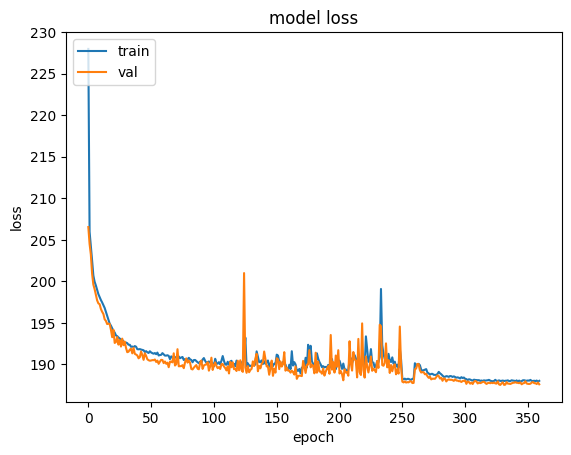

In [29]:
comb_hist_loss = history.history['loss'] + history2.history['loss'] + history3.history['loss'] + history4.history['loss'] + history5.history['loss'] + history6.history['loss'] + history7.history['loss'] + history8.history['loss'] + history9.history['loss'] + history10.history['loss']
comb_hist_val_loss = history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss'] + history5.history['val_loss'] + history6.history['val_loss'] + history7.history['val_loss'] + history8.history['val_loss'] + history9.history['val_loss'] + history10.history['val_loss']

plt.plot(comb_hist_loss)
plt.plot(comb_hist_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

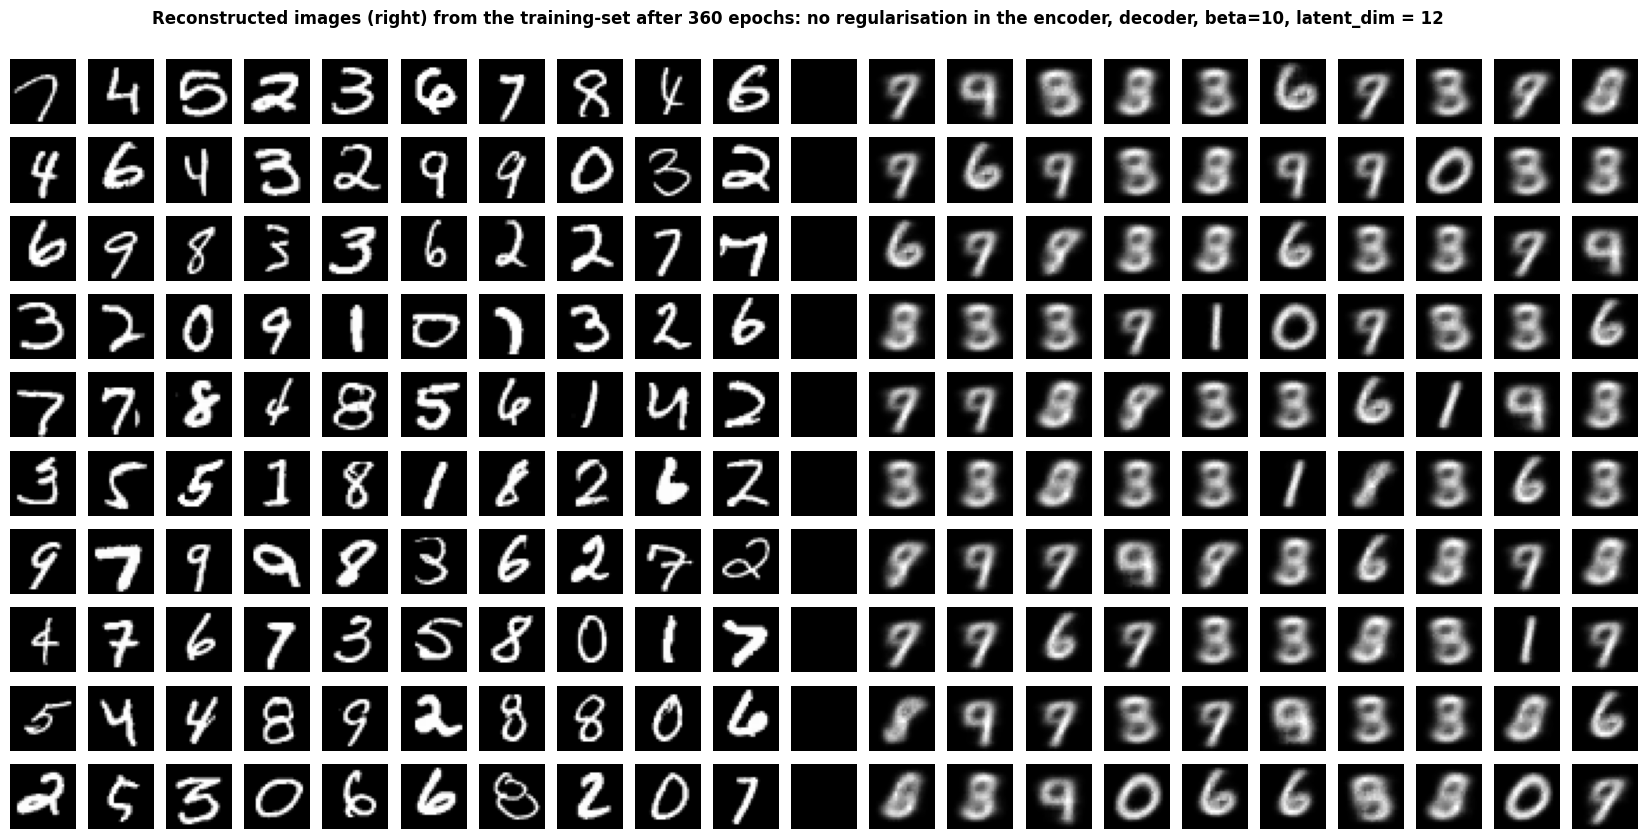

In [31]:
plot_reconstruction(img_train,'training',111,360,10)

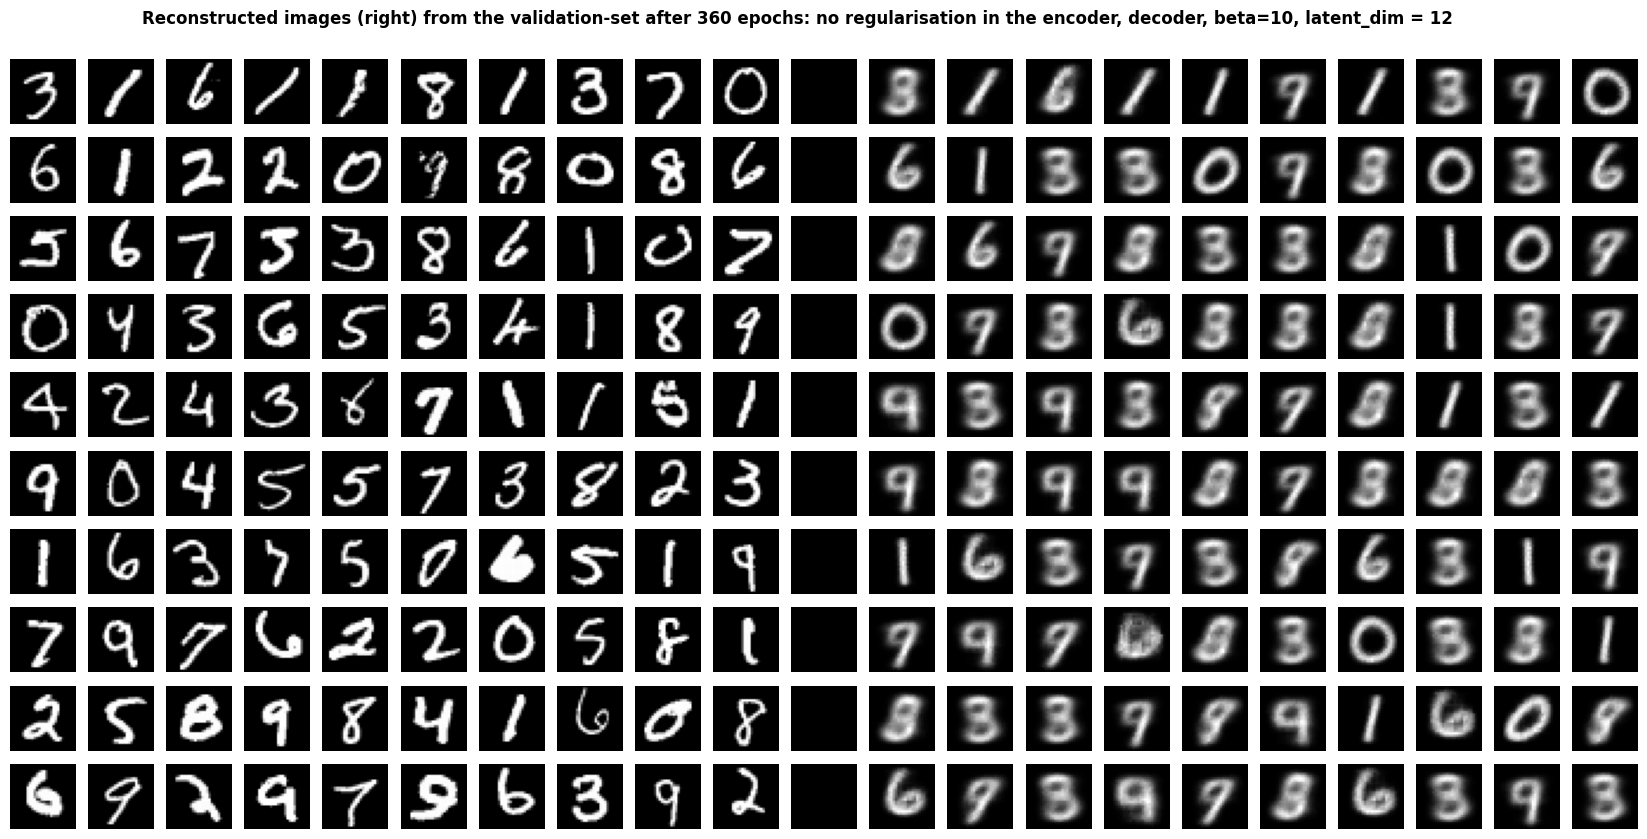

In [32]:
plot_reconstruction(img_valid,'validation',555,360,10)

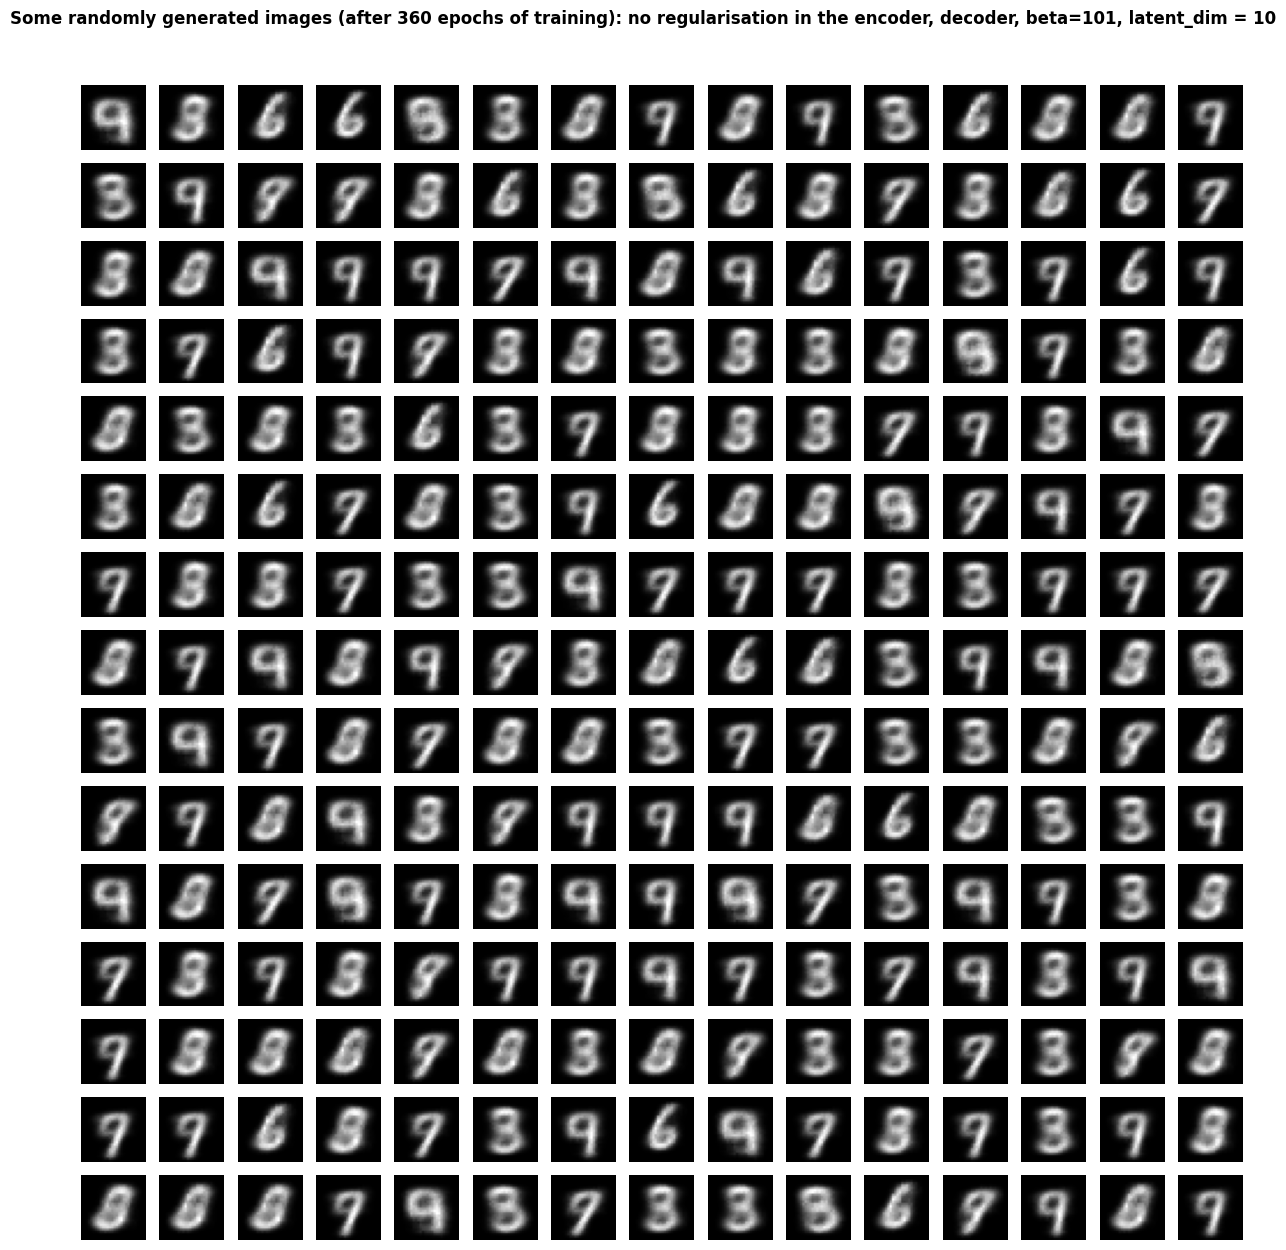

In [33]:
plot_generated(1,15,333,360,10)

the images are too blurry coz of the weight attached to the kl termreconsrecrrte im#thnmmm

## **beta=3**

In [ ]:
beta=3

def vae_loss_5(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [ ]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=50000, decay_rate=0.994, staircase=True)
optim = keras.optimizers.Adam(learning_rate = 0.001)
VAE.compile(optimizer=optim,loss=vae_loss_5)

In [ ]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=500, steps_per_epoch=None)

Epoch 1/500
625/625 [==============================] - 24s 13ms/step - loss: 226.7181 - val_loss: 200.7282
Epoch 2/500
625/625 [==============================] - 7s 12ms/step - loss: 196.3218 - val_loss: 193.1702
Epoch 3/500
625/625 [==============================] - 7s 12ms/step - loss: 192.1475 - val_loss: 190.7297
Epoch 4/500
625/625 [==============================] - 7s 12ms/step - loss: 189.8126 - val_loss: 187.8976
Epoch 5/500
625/625 [==============================] - 7s 12ms/step - loss: 187.1418 - val_loss: 186.4746
Epoch 6/500
625/625 [==============================] - 8s 12ms/step - loss: 183.4468 - val_loss: 181.3506
Epoch 7/500
625/625 [==============================] - 7s 11ms/step - loss: 179.7084 - val_loss: 177.1695
Epoch 8/500
625/625 [==============================] - 7s 12ms/step - loss: 176.4285 - val_loss: 174.8419
Epoch 9/500
625/625 [==============================] - 7s 11ms/step - loss: 174.4052 - val_loss: 172.9254
Epoch 10/500
625/625 [=======================

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.0001)        # looks like we got stuck in some local minima with too low of a lr towards the end of the last 500 epochs
VAE.compile(optimizer=optim,loss=vae_loss_5)
history2 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=50, steps_per_epoch=None)

Epoch 1/50
625/625 [==============================] - 13s 12ms/step - loss: 146.8911 - val_loss: 147.0949
Epoch 2/50
625/625 [==============================] - 6s 10ms/step - loss: 146.5506 - val_loss: 146.9154
Epoch 3/50
625/625 [==============================] - 7s 12ms/step - loss: 146.4144 - val_loss: 146.9084
Epoch 4/50
625/625 [==============================] - 7s 11ms/step - loss: 146.3819 - val_loss: 146.8393
Epoch 5/50
625/625 [==============================] - 7s 11ms/step - loss: 146.3504 - val_loss: 146.9575
Epoch 6/50
625/625 [==============================] - 6s 10ms/step - loss: 146.2850 - val_loss: 146.7975
Epoch 7/50
625/625 [==============================] - 7s 10ms/step - loss: 146.1985 - val_loss: 146.6611
Epoch 8/50
625/625 [==============================] - 7s 11ms/step - loss: 146.2501 - val_loss: 146.7658
Epoch 9/50
625/625 [==============================] - 6s 10ms/step - loss: 146.2852 - val_loss: 146.8310
Epoch 10/50
625/625 [==============================] -

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.000015)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history3 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)        # trying to explore nearby with a slightly higher lr

Epoch 1/10
625/625 [==============================] - 15s 11ms/step - loss: 145.3102 - val_loss: 146.0359
Epoch 2/10
625/625 [==============================] - 12s 19ms/step - loss: 145.2753 - val_loss: 146.0508
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 145.3337 - val_loss: 146.0788
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 145.3486 - val_loss: 146.0335
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2927 - val_loss: 146.0188
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 145.2860 - val_loss: 146.0091
Epoch 7/10
625/625 [==============================] - 9s 14ms/step - loss: 145.3126 - val_loss: 146.0598
Epoch 8/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2995 - val_loss: 146.0351
Epoch 9/10
625/625 [==============================] - 6s 10ms/step - loss: 145.3864 - val_loss: 146.1176
Epoch 10/10
625/625 [==============================] 

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.000009)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history4 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 12ms/step - loss: 145.3227 - val_loss: 145.9402
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 145.2495 - val_loss: 145.9586
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2777 - val_loss: 145.8863
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2677 - val_loss: 146.0274
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2521 - val_loss: 145.9363
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2562 - val_loss: 146.0042
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2179 - val_loss: 145.9400
Epoch 8/10
625/625 [==============================] - 7s 11ms/step - loss: 145.3071 - val_loss: 146.0423
Epoch 9/10
625/625 [==============================] - 6s 10ms/step - loss: 145.2675 - val_loss: 145.9838
Epoch 10/10
625/625 [==============================] -

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.00001)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history5 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 11ms/step - loss: 145.2195 - val_loss: 146.0143
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2287 - val_loss: 146.0428
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2450 - val_loss: 146.0251
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2206 - val_loss: 145.9720
Epoch 5/10
625/625 [==============================] - 7s 10ms/step - loss: 145.2942 - val_loss: 146.0210
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2621 - val_loss: 146.0065
Epoch 7/10
625/625 [==============================] - 7s 10ms/step - loss: 145.2806 - val_loss: 146.0368
Epoch 8/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2245 - val_loss: 145.9604
Epoch 9/10
625/625 [==============================] - 8s 13ms/step - loss: 145.2070 - val_loss: 146.0308
Epoch 10/10
625/625 [==============================] -

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.000009)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history6 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 13s 11ms/step - loss: 145.1803 - val_loss: 146.0186
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2013 - val_loss: 145.9519
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 145.2313 - val_loss: 145.8632
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2186 - val_loss: 145.9826
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2125 - val_loss: 145.9484
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 145.1856 - val_loss: 145.8726
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2157 - val_loss: 146.0232
Epoch 8/10
625/625 [==============================] - 6s 10ms/step - loss: 145.2168 - val_loss: 146.0292
Epoch 9/10
625/625 [==============================] - 7s 11ms/step - loss: 145.1964 - val_loss: 145.9585
Epoch 10/10
625/625 [==============================] -

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.0000095)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history7 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 [==============================] - 15s 11ms/step - loss: 145.2080 - val_loss: 146.0116
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2341 - val_loss: 145.8445
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 145.1459 - val_loss: 145.9943
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 145.2193 - val_loss: 146.0155
Epoch 5/10
625/625 [==============================] - 7s 12ms/step - loss: 145.1714 - val_loss: 145.9183
Epoch 6/10
625/625 [==============================] - 7s 10ms/step - loss: 145.1911 - val_loss: 145.9576
Epoch 7/10
625/625 [==============================] - 7s 12ms/step - loss: 145.1945 - val_loss: 145.9709
Epoch 8/10
625/625 [==============================] - 7s 11ms/step - loss: 145.1809 - val_loss: 145.9342
Epoch 9/10
625/625 [==============================] - 8s 12ms/step - loss: 145.1347 - val_loss: 145.9012
Epoch 10/10
625/625 [==============================] -

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.0000095)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history8 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, steps_per_epoch=None)

Epoch 1/30
625/625 [==============================] - 13s 11ms/step - loss: 145.1803 - val_loss: 145.8960
Epoch 2/30
625/625 [==============================] - 7s 11ms/step - loss: 145.2320 - val_loss: 145.9759
Epoch 3/30
625/625 [==============================] - 6s 10ms/step - loss: 145.1772 - val_loss: 145.9701
Epoch 4/30
625/625 [==============================] - 7s 11ms/step - loss: 145.1605 - val_loss: 145.9655
Epoch 5/30
625/625 [==============================] - 8s 12ms/step - loss: 145.1053 - val_loss: 145.9620
Epoch 6/30
625/625 [==============================] - 6s 10ms/step - loss: 145.2128 - val_loss: 145.9318
Epoch 7/30
625/625 [==============================] - 7s 11ms/step - loss: 145.1738 - val_loss: 145.8801
Epoch 8/30
625/625 [==============================] - 7s 10ms/step - loss: 145.1987 - val_loss: 145.9089
Epoch 9/30
625/625 [==============================] - 7s 11ms/step - loss: 145.1537 - val_loss: 145.9855
Epoch 10/30
625/625 [==============================] -

The performance on the training set is increasing marginally, but the performance on the validation hasn't improved significantly in a while. We're going to take that as a sign that this is a reasonable place to stop training.

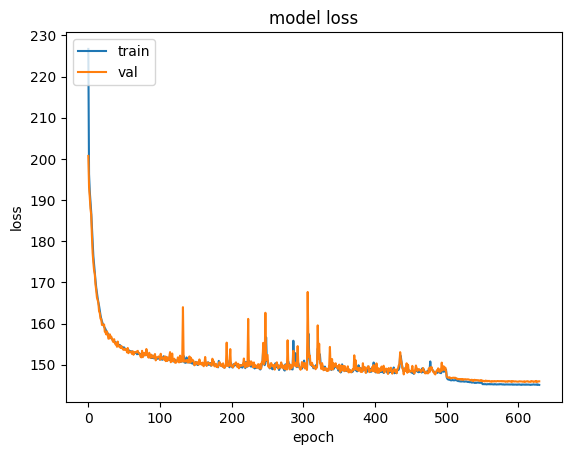

In [ ]:
comb_hist_loss = history.history['loss']+ history2.history['loss']+ history3.history['loss']+ history4.history['loss']+ history5.history['loss']+ history6.history['loss']+ history7.history['loss']+ history8.history['loss']
comb_hist_val_loss = history.history['val_loss']+ history2.history['val_loss']+ history3.history['val_loss']+ history4.history['val_loss']+ history5.history['val_loss']+ history6.history['val_loss']+ history7.history['val_loss']+ history8.history['val_loss']

plt.plot(comb_hist_loss)
plt.plot(comb_hist_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

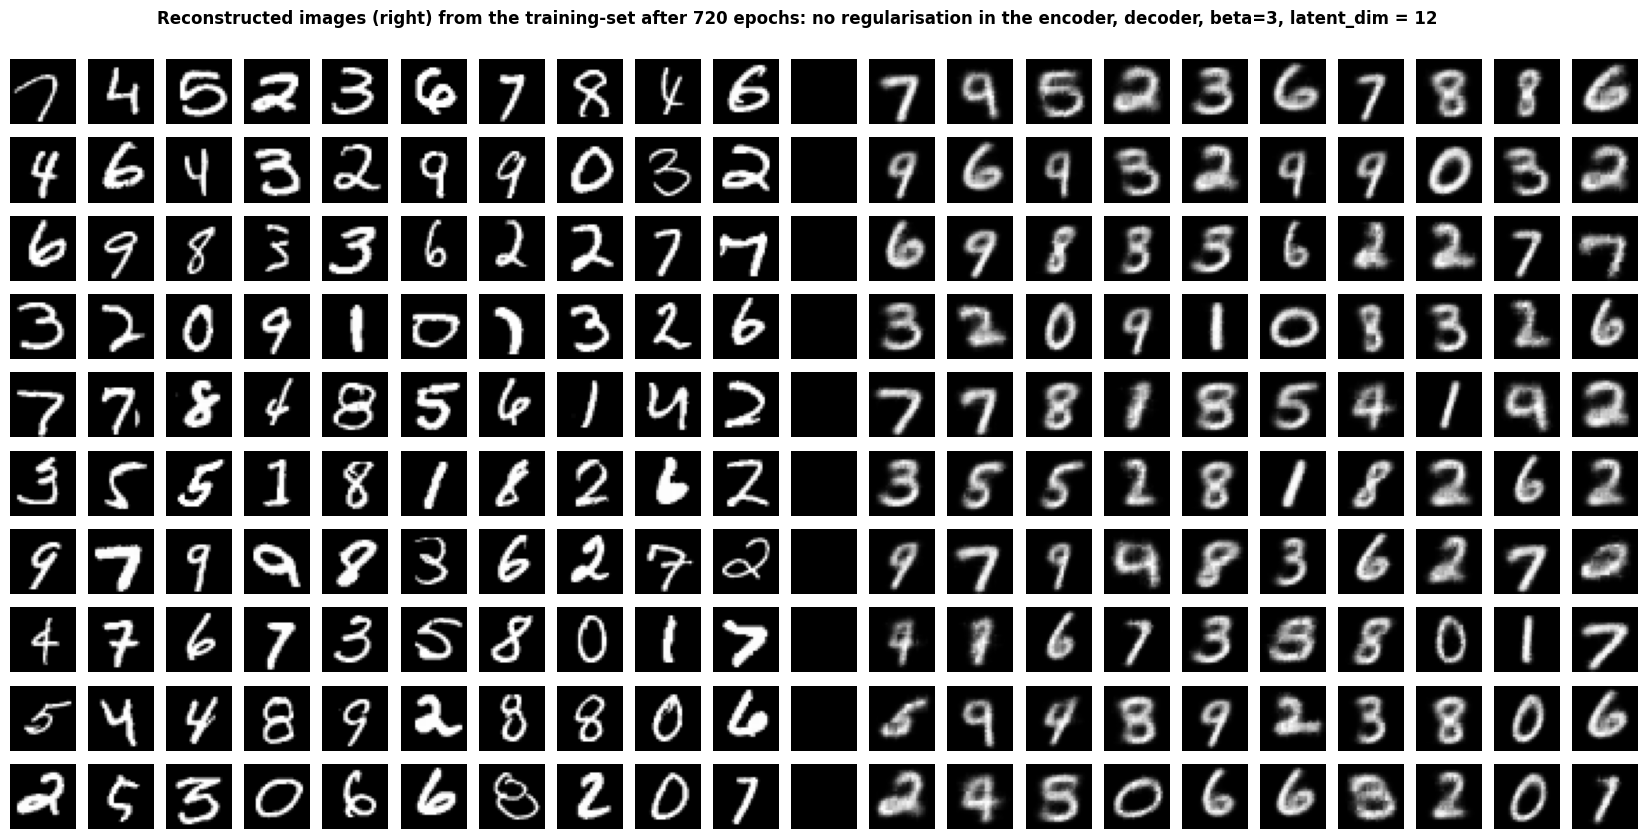

In [ ]:
plot_reconstruction(img_train,'training',111,720,3)

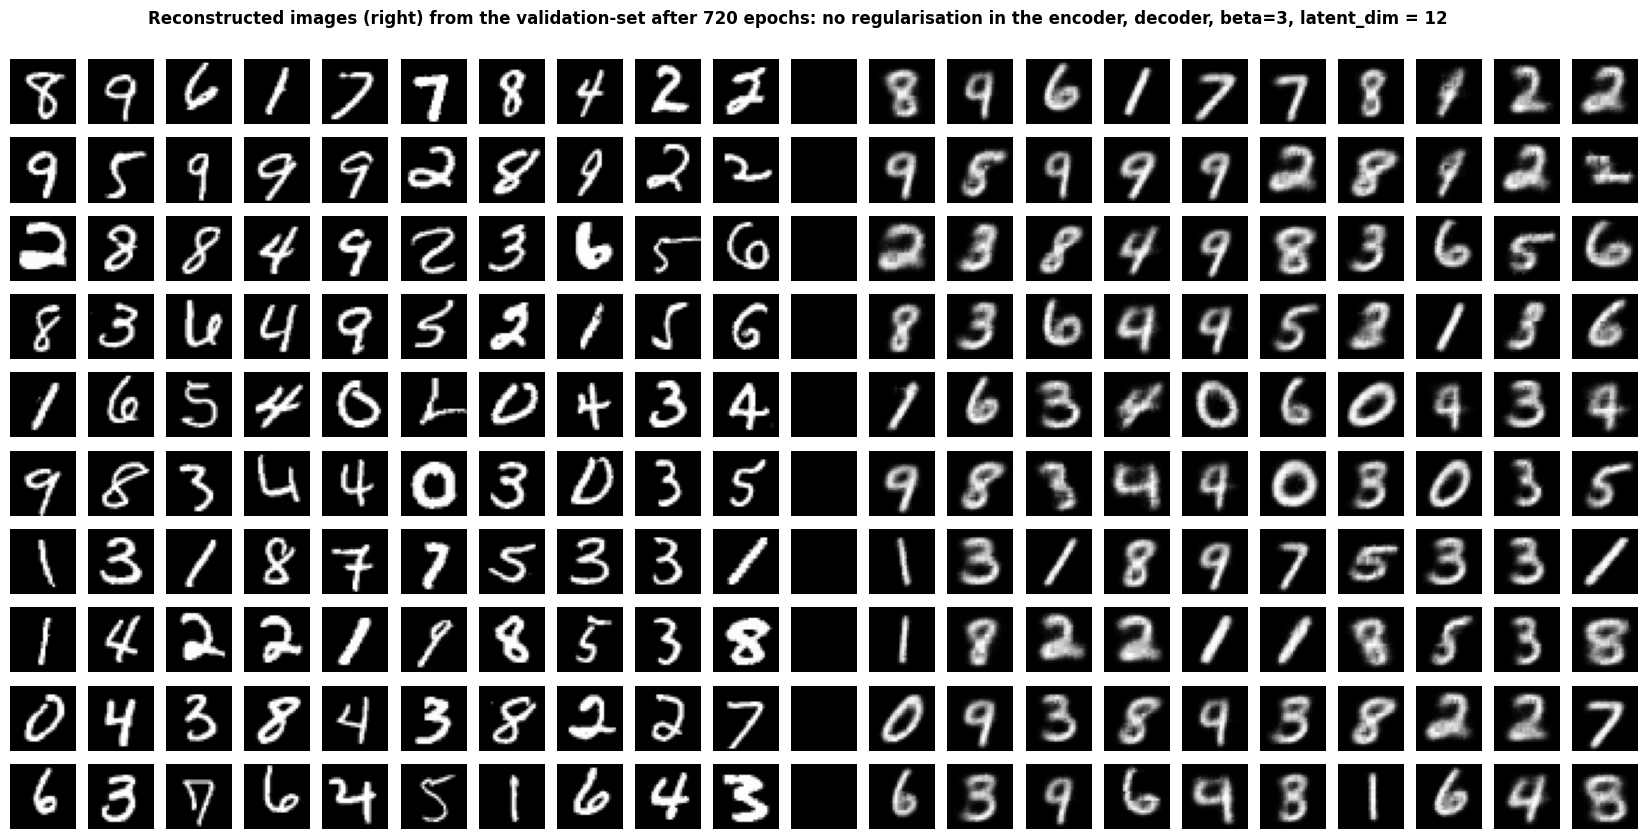

In [ ]:
plot_reconstruction(img_valid,'validation',111,720,3)

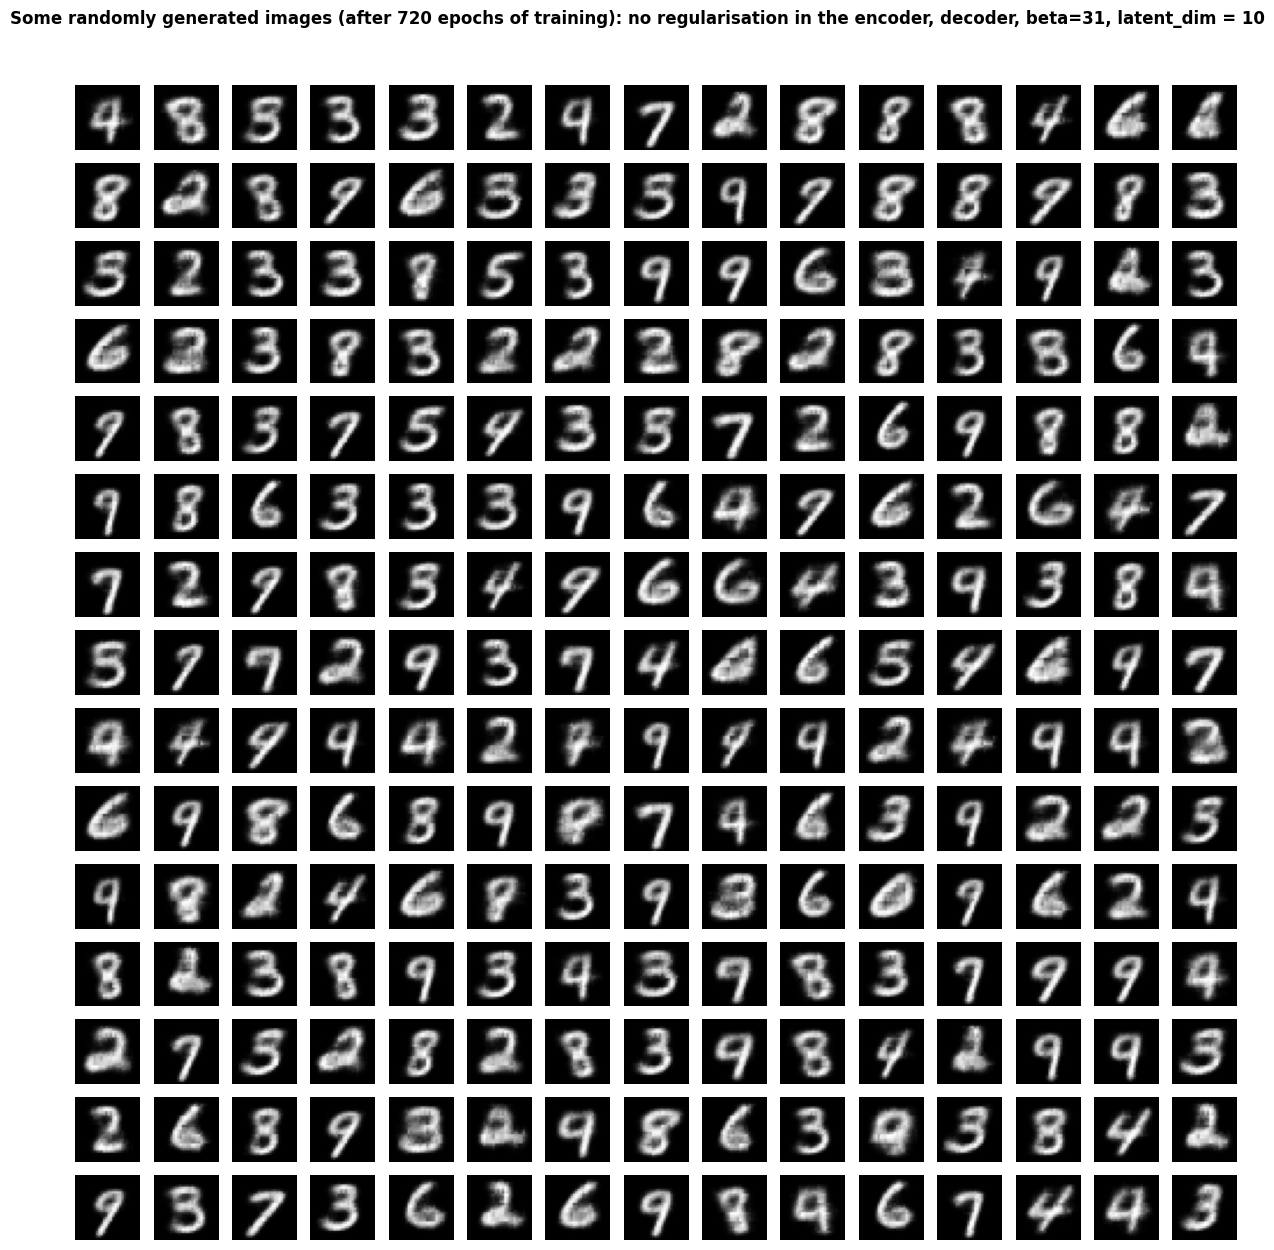

In [ ]:
plot_generated(1,15,123,720,3)

The improvement from beta=1 to beta=3 (the model with the latter should be equally well-trained if not a little better than the previous) seems to be that the quality is more averaged out and uniform, especially for the generated images. The generated images are a little smoother but also more blurry (which is expected I guess).